In [1]:
install.packages('tidyquant')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘tune’, ‘workflowsets’, ‘forecast’, ‘tsfeatures’, ‘tidymodels’, ‘alphavantager’, ‘timetk’




In [ ]:
library(tidyverse)
library(broom)
library(tidyquant)
options(dplyr.summarise.inform = FALSE)

# Predict the market by only looking at the previous performance

## Preparation

In [4]:
rhg_cols <- c("#8c2ead","#25db73","#c734ae","#b2ea69","#262d95","#dbc51f","#657fff","#ffab46","#424d89",
"#008d3d","#ff7eef","#2c7448","#9b000d","#60efdb","#890050","#c4e39a","#ecb8ff","#8f4300","#008b70","#ff725d")
# get some colors

In [5]:
# NYSE <- as.vector(tq_exchange('NYSE')[[1]])
# NASDAQ <- as.vector(tq_exchange('NASDAQ')[[1]])
# tickers <- c(NYSE, NASDAQ)
# tickers <- tickers[!str_detect(tickers,"\\^")]
# tickers <- tickers[!str_detect(tickers,"\\/")] # get almost all stocks in the US
# sample_tickers <- sample(tickers,100)

# if you want to play with other stocks, use this code

In [6]:
stock_n = c('AMZN', 'AAPL','GE','XOM','MS','TSLA','UAL','NVDA','MMM','LW')
# stock_n = c("TGT", "GOOGL", "AMZN", "SBUX", "INTC", "MU", "LRCX", "NVDA",
# "GPS", "AXP", "XOM", "COP", "AMD", "AMC", "TSLA", "JPM", "BAC", "KR",
# "DLTR", "WMT", "COST", "LW", "GS", "DAL", "MS", "UAL", "NFLX", "GE",
# "REPX", "ALK", "CNI", "TSM", "MSFT", "HD", "YUM", "MRVL", "MMM",
# "RIVN", "WFC", "CVS", "WBA", "DKS", "WCC", "GM", "UBER", "ENPH","LOW") # choose stocks you want to examine
# stock_n = sample_tickers # take a random look

In [7]:
STK <- tq_get(stock_n, get = "stock.prices", from = "2018-01-03")
INX <- tq_get('SPY', get = "stock.prices", from = "2018-01-03")
# set stocks and index as the reference

In [8]:
STK <- STK|>
  group_by(symbol) |>
  mutate(change = (close - first(open))/first(open) * 100)

INX <- INX |>
  mutate(change = (close - first(open))/first(open) * 100)

In [9]:
STK <- STK |>
  mutate(year = year(date), month = month(date), week = week(date)) |>
  group_by(symbol, year,week) |>
  mutate(first_w_open = first(open),
         change_in_w = ((close - first_w_open) / first_w_open)*100,
         change_by_w = ((last(close) - first_w_open) / first_w_open)*100)

INX <- INX |>
  mutate(year = year(date), month = month(date), week = week(date)) |>
  group_by(year, week) |>
  mutate(first_w_open = first(open),
         change_in_w = ((close - first_w_open) / first_w_open)*100,
         change_by_w = ((last(close) - first_w_open) / first_w_open)*100)

In [10]:
joined <- left_join(STK, INX[,c('date','change','change_in_w','change_by_w')], by = "date", suffix = c("_STK", "_INX"))
joined <- joined |>
  group_by(symbol, year, week) |>
  mutate(diff_change = change_by_w_STK - change_by_w_INX,
         beat = if_else(diff_change>0, 1, 0))

## Take a look at overall performance

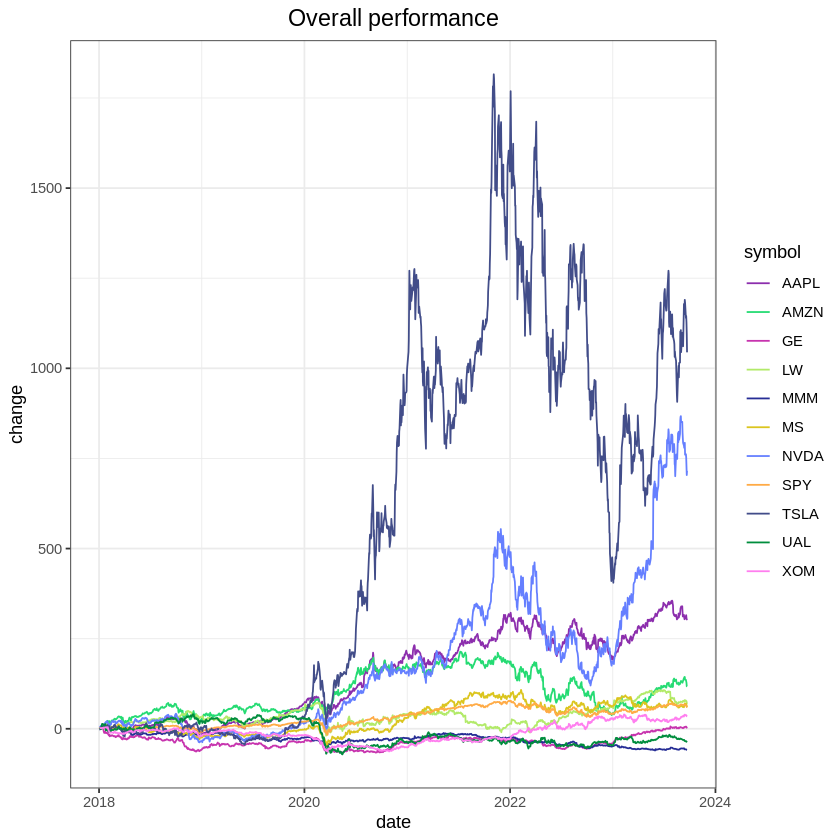

In [11]:
if (length(stock_n) < 20) {
    STK |>
      bind_rows(INX) |>
      ggplot()+
      theme_bw()+
      geom_line(aes(x=date, y =change, color = symbol))+
      theme(plot.title = element_text(size=14, hjust = 0.5))+
      labs(title = "Overall performance")+
      scale_color_manual(values = rhg_cols)} else
    {print("Too many tickers to graph!")}

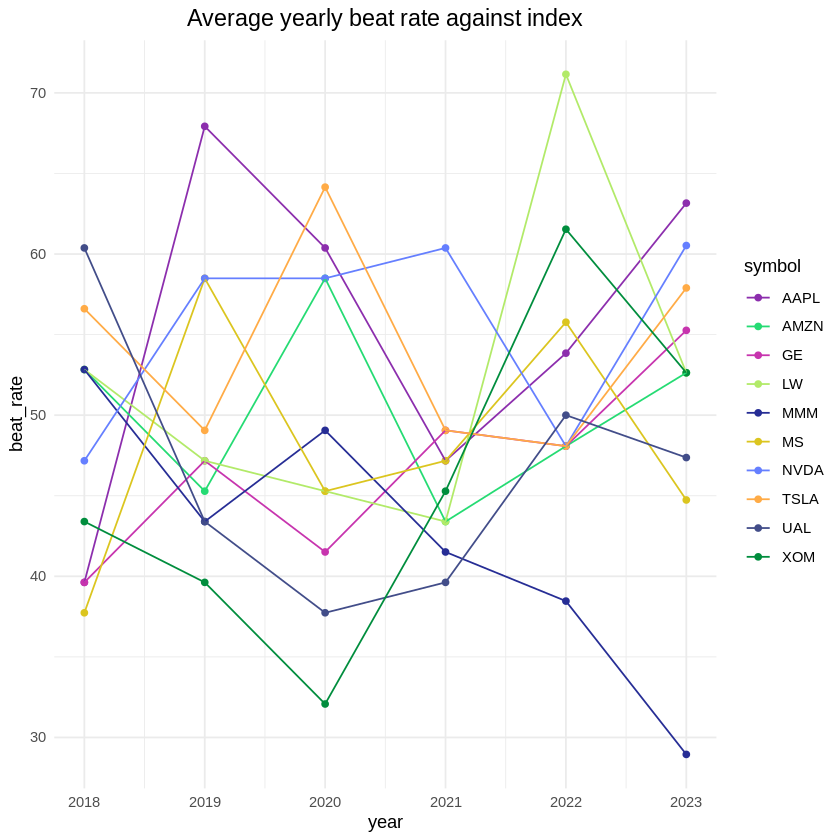

In [12]:
if (length(stock_n) < 20) {
    joined |>
      group_by(symbol,year, week) |>
      distinct(symbol,year, week, beat) |>
      ungroup() |>
      group_by(symbol, year) |>
      summarise(beat_rate = (sum(beat) / last(week)*100)) |>
      ggplot(aes(x=year, y=beat_rate, color = symbol))+
      theme_minimal()+
      geom_point()+
      geom_line()+
      theme(plot.title = element_text(size=14, hjust = 0.5))+
      labs(title = "Average yearly beat rate against index")+
      scale_color_manual(values = rhg_cols)}  else
    {print("Too many tickers to graph!")}

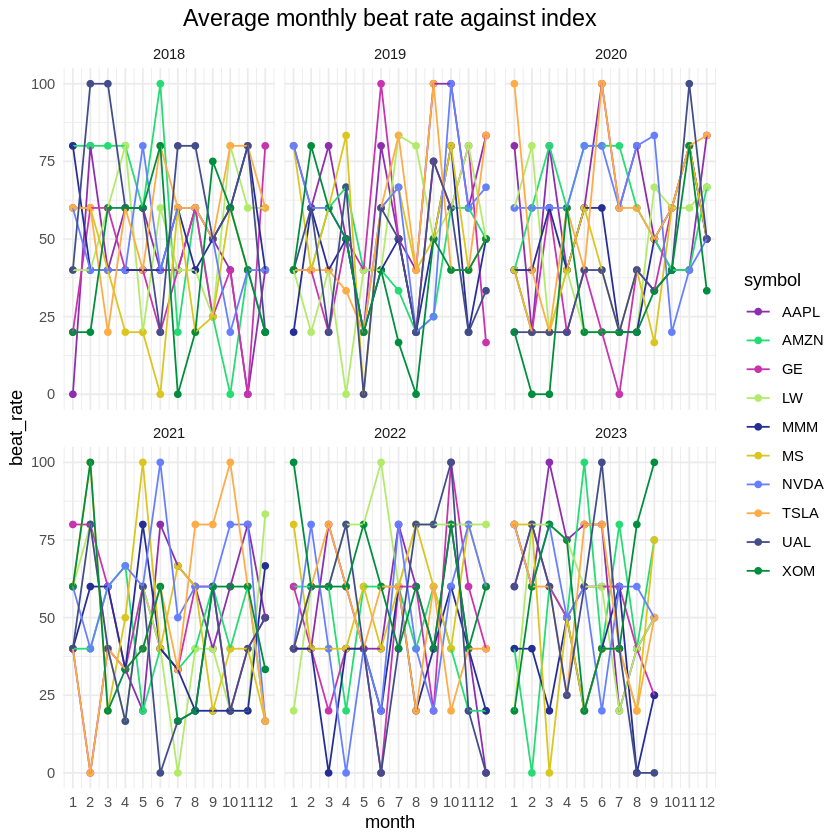

In [13]:
if (length(stock_n) < 20) {
    joined |>
      group_by(symbol,year, week) |>
      distinct(symbol,year, week, month, beat) |>
      ungroup() |>
      group_by(symbol,year, month) |>
      summarise(beat_rate = (sum(beat) / n_distinct(week)*100)) |>
      ungroup() |>
      ggplot(aes(x=month, y=beat_rate, color = symbol))+
      theme_minimal()+
      scale_x_continuous(breaks=seq(1, 12, 1))+
      geom_point()+
      geom_line()+
      theme(plot.title = element_text(size=14, hjust = 0.5))+
      labs(title = "Average monthly beat rate against index")+
      facet_wrap(~year)+
      scale_color_manual(values = rhg_cols)}  else
    {print("Too many tickers to graph!")}

## Momentum analysis

The idea behind the 'momentum' is straightforward: it's about whether a stock's performance today depends on its performance before. In my case, the momentum is measured in weeks, and the evaluation of performance is whether it performs better than the index during that week. Economic theory says momentum should not be the deal, and we want to see whether it is true.

In [ ]:
time_period <- 4 # Since we are rolling apply weeks, it should be larger than 1

mmt <- joined |>
  distinct(symbol,year, week, beat) |>
  ungroup() |>
  group_by(symbol) |>
  mutate(mmt = rollapply(beat, width = time_period, FUN = sum, fill = NA, align = "right"),
         next_beat = lead(beat, default = NA)) |> #NA for the closest week
  filter(!is.na(mmt))

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”


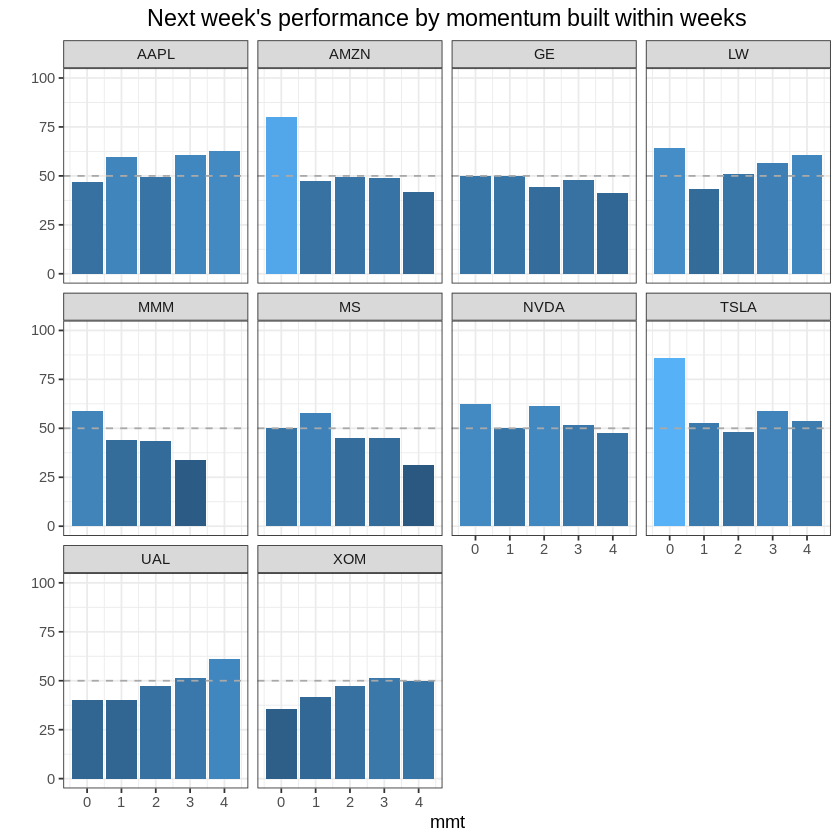

In [15]:
if (length(stock_n) < 20) {
    mmt |>
      group_by(symbol, mmt) |>
      summarise(beat_r = sum(next_beat, na.rm = T)/n()*100, n=n()) |>
    # Compromise, when calculating the beat rate,
    # I tend to include the closest week in the total number.
    # Although it is NA, if I drop the NA, it will drop the row for the whole week,
    # which will not yield a result.
      ggplot(aes(x=mmt, y = beat_r, fill = beat_r)) +
      theme_bw()+
      geom_col()+
      scale_fill_continuous()+
      geom_hline(yintercept = 50, linetype = "dashed", color = 'darkgrey')+
      facet_wrap(~symbol)+
      guides(fill = FALSE) +
      theme(plot.title = element_text(size=14, hjust = 0.5))+
      labs(y='',
           title = "Next week's performance by momentum built within weeks",
           fill = '')+
      ylim(0,100)}  else
    {print("Too many tickers to graph!")}

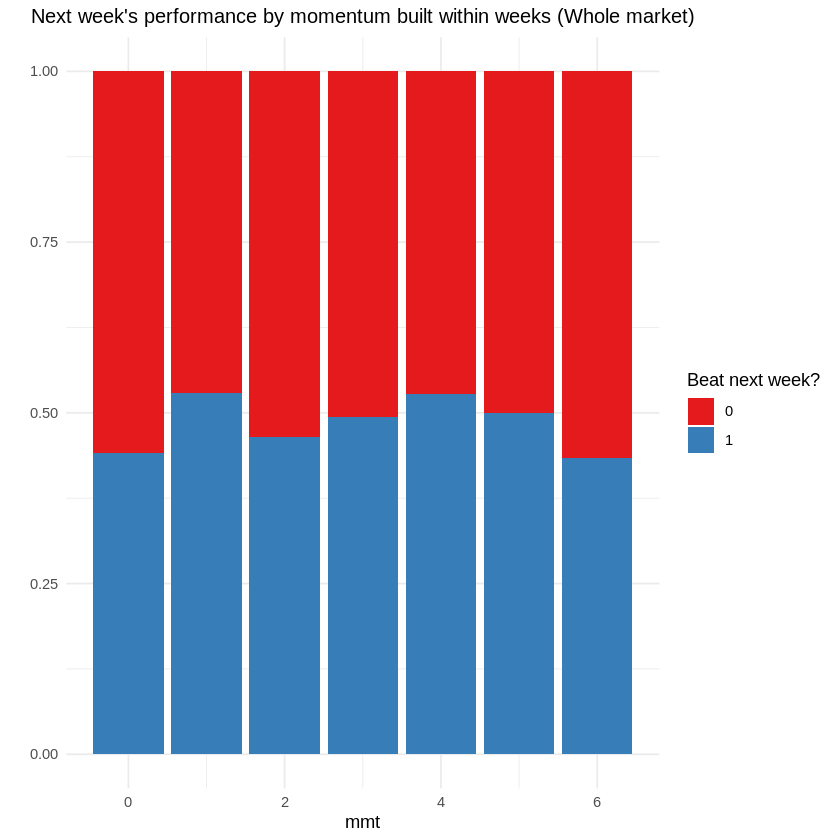

In [24]:
mmt |>
  filter(!is.na(next_beat)) |> #We have enough data, so it is fine to drop these NAs
  ggplot(aes(x=mmt, fill = factor(next_beat)))+
  theme_minimal()+
  geom_bar(position = 'fill')+
  scale_fill_brewer(palette = "Set1")+
  theme(plot.title = element_text(size=12, hjust = 0.5))+
  labs(y='',
       title = "Next week's performance by momentum built within weeks (Whole market)",
       fill =  "Beat next week?")

In [17]:
beat_rate <- mmt |>
  group_by(symbol, mmt) |>
  summarise(beat_r = sum(next_beat, na.rm = T)/n()*100, n=n())

last <- mmt |>
  arrange(year, week) |>
  group_by(symbol) |>
  summarise(last_mmt = last(mmt))

beat_rate |>
  inner_join(last, by = c('symbol', 'mmt' = 'last_mmt')) |>
  arrange(desc(beat_r))
# This is to find out which stock I should buy by looking at last week's momentum
# in order to get the highest possibility of beating the market.

symbol,mmt,beat_r,n
<chr>,<dbl>,<dbl>,<int>
NVDA,2,61.26126,111
LW,2,51.04167,96
GE,1,50.00000,78
XOM,4,50.00000,14
AAPL,2,49.58678,121
AMZN,3,48.68421,76
TSLA,2,48.00000,100
MS,3,44.92754,69
MMM,1,43.85965,114


In [18]:
result <- tibble(symbol = character(),
                mmt = double(),
                beat_r = double(),
                n = integer())
for (x in 2:6){
  time_period <- x

  mmt <- joined |>
    distinct(symbol,year, week, beat) |>
    ungroup() |>
    group_by(symbol) |>
    mutate(mmt = rollapply(beat, width = time_period, FUN = sum, fill = NA, align = "right"),
           next_beat = lead(beat, default = NA)) |> #NA for the closest week
    filter(!is.na(mmt))

  beat_rate <- mmt |>
    group_by(symbol, mmt) |>
    summarise(beat_r = sum(next_beat, na.rm = T)/n()*100, n=n(),
              beated = sum(next_beat, na.rm = T))

  last <- mmt |>
    arrange(year, week) |>
    group_by(symbol) |>
    summarise(last_mmt = last(mmt))

  iter_result <- beat_rate |>
    inner_join(last, by = c('symbol', 'mmt' = 'last_mmt')) |>
    arrange(desc(beat_r))

  result <- result |>
    bind_rows(iter_result)}

result |>
  group_by(symbol) |>
  summarise(avg_beat_r = sum(beat_r * n)/sum(n), beated_t = sum(beated), n = sum(n)) |>
  arrange(desc(avg_beat_r))

# Different time period settings will yield different beat rates,
# but if we take the weighted average for each beat rate for each time period we set,
# we will get a more fair value

symbol,avg_beat_r,beated_t,n
<chr>,<dbl>,<dbl>,<int>
NVDA,57.40741,341,594
AAPL,53.81679,282,524
LW,52.00803,259,498
TSLA,51.71790,286,553
GE,50.23585,213,424
AMZN,49.00542,271,553
MS,48.16248,249,517
XOM,46.15385,78,169
MMM,43.61702,205,470


This result depends on the data we gathered at the beginning. By default, the data ends today or yesterday, and the prediction is reasonable for next week.

## Further exploration

In [19]:
joined |>
  group_by(symbol) |>
  summarize(correlation = cor(change_by_w_INX, change_by_w_STK)) |>
  arrange(desc(correlation))

symbol,correlation
<chr>,<dbl>
AAPL,0.7109909
MS,0.6883078
AMZN,0.6627971
NVDA,0.6616511
MMM,0.6459525
TSLA,0.4852271
XOM,0.4812516
GE,0.4520747
UAL,0.4354772


`geom_smooth()` using formula = 'y ~ x'


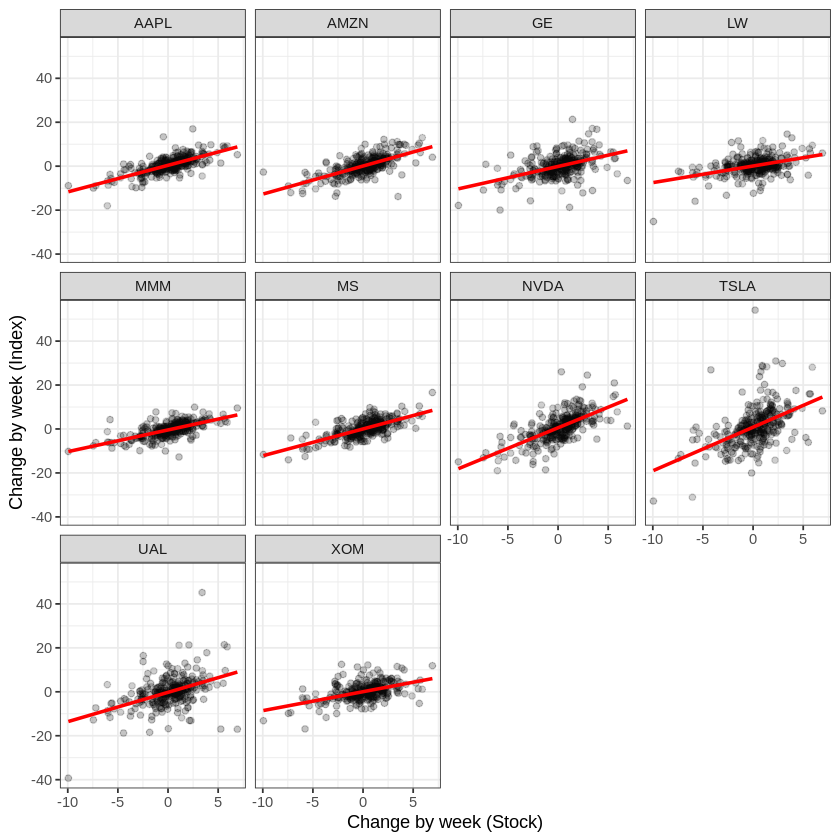

In [20]:
if (length(stock_n) < 20) {
    joined |>
      ggplot(aes(x=change_by_w_INX, y=change_by_w_STK))+
      theme_bw()+
      geom_point(alpha = 0.05)+
      geom_smooth(method = "lm", se = F, color = "red")+
      facet_wrap(~symbol)+
      labs(x='Change by week (Stock)', y='Change by week (Index)')}  else
    {print("Too many tickers to graph!")}

In [21]:
joined |>
  nest(data = -symbol) |>
  mutate(model = map(data, ~lm(change_STK ~ change_INX, data=.)),
         tidied = map(model, tidy)) |>
  unnest(tidied)

These correlations are about the volatility of stock movement, just for fun.